In [43]:
%matplotlib inline
import scipy.io as sio
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [44]:
data_file = 'hwkdataNEW.mat'
data_dict = sio.loadmat(data_file)

In [45]:
print(data_dict.keys())

dict_keys(['__header__', '__version__', '__globals__', 'x', 'y'])


In [46]:
x = data_dict['x']
y = data_dict['y']

In [47]:
x.shape

(247, 14)

In [48]:
y.shape

(247, 1)

In [60]:
column_names = ['Age', 'Weight', 'Height', 'Adiposity Index', 
                'Neck Circumference', 'Chest Circumference', 
                'Abdomen Circumference', 'Hip Circumference',
                'Thigh Circumference', 'Knee Circumference',
                'Ankle Circumference', 'Extended Bicep Circumference',
                'Forearm Circumference', 'Wrist Circumference',
                'Body Fat Percentage']

# Split the data

Since the data consists of independent observations, we can shuffle the data set and select the first 70% for training, the second 15% for validation, and the last 15% for testing and reporting. If we expected a relationship between individual rows a more complicated sleection technique would be required (e.g. windowshading) that both allowed for data "stripes" of sufficient size to capture the inter-row relationships while being small enough to allow enough random samples in the data to make sure the model wasn't overtrained on some subset of the data.

First, join the input and output matrices to ensure we select associated records

In [49]:
data = np.concatenate([x, y], axis=1)
print(data.shape)

(247, 15)


In [50]:
unshuffled_first_row = data[0].copy()

In [51]:
np.random.shuffle(data)

In [52]:
assert not(np.array_equal(unshuffled_first_row, data[0]))

Now that the data is shuffled we can select the first 70% for training, 15% for validation, and 15% for testing.

In [53]:
rows = data.shape[0]
train_length = int(0.7 * rows)
val_length = int(0.15 * rows)
test_length = int(0.15 * rows)
print(f'70% of the data set is {train_length} rows')
print(f'15% of the data set is {val_length}')
# Ensure we are not leaving any data on the table
# Any extra rows we will throw into the training set
extra_rows = rows - train_length - val_length - test_length
print(f'There are {extra_rows} extra rows to add back to the training set')
train_length += extra_rows
print(f'The training set will have {train_length} rows')
print(f'The training set will have {val_length} rows')
print(f'The training set will have {test_length} rows')
print(f'There are a total of {train_length + val_length + test_length} rows of data')
# A test to make sure all data are being used
assert train_length + val_length + test_length == data.shape[0]

70% of the data set is 172 rows
15% of the data set is 37
There are 1 extra rows to add back to the training set
The training set will have 173 rows
The training set will have 37 rows
The training set will have 37 rows
There are a total of 247 rows of data


In [54]:
data_train = data[:train_length,:]
data_val = data[train_length:train_length+val_length,:]
data_test = data[train_length+val_length:,:]
print(f'The training set has {data_train.shape[0]} rows')
print(f'The validation set has {data_val.shape[0]} rows')
print(f'The testing set has {data_test.shape[0]} rows')

The training set has 173 rows
The validation set has 37 rows
The testing set has 37 rows


In order to ensure that the training set covers the entire range of our data set, we must find the row that contains the minimum and maximum of each of the input variables.

In [55]:
# Get the row numbers corresponding to maximum and minimum values in each column
max_indices = data.argmax(axis=0)
min_indices = data.argmin(axis=0)
# Join the two arrays of indices together
min_max_indices = np.append(max_indices, min_indices)
# Collapse the index arrays to their unique values
min_max_indices = np.unique(min_max_indices)
# Add that array to the training set
for rownum in min_max_indices:
    data_train = np.vstack([data_train, data[rownum]])
# Check the size of our training set now
print(f'The training set now has {data_train.shape[0]} rows')

The training set now has 190 rows


Filter duplicate rows from `data_train`. We don't want to overtrain on those rows.

In [56]:
data_train = np.unique(data_train, axis=0)
print(f'Training data now has {data_train.shape[0]} unique rows')

Training data now has 179 unique rows


# Solve matrix equation to find regression coefficients

We now have three data sets, `data_train`, `data_val`, and `data_test`. We can now fit a parametric linear regression model to fit the form $y = \sum_i a_i x_i + b$. We will do this by solving the equation $ \mathbf{x} \vec{a} = \vec{y} $, where the matrix $\mathbf{x}$ is right-padded with a column vector of $1$s in order to fit the last element of $\vec{a}$, representing the $y$-axis intercept. The naive solution to this is:
$$ 
    \mathbf{x}^{-1} \mathbf{x} \vec{a} = \mathbf{x}^{-1} \mathbf{x} \vec{y} \\
    \vec{a} = \mathbf{x}^{-1} \mathbf{x} \vec{y} 
$$
Since $\mathbf{x}$ is not square, however, we must replace the inverse with the pseudoinverse:
$$
    \mathbf{x}^T \mathbf{x} \vec{a} = \mathbf{x}^T \vec{y} \\
    \left( \mathbf{x}^T \mathbf{x} \right)^{-1} \left( \mathbf{x}^T \mathbf{x} \right) \vec{a} = \left( \mathbf{x}^T \mathbf{x} \right)^{-1} \mathbf{x}^T \vec{y} \\
    \vec{a} = \left( \mathbf{x}^T \mathbf{x} \right)^{-1} \mathbf{x}^T \vec{y}
$$

In [57]:
data_train_x = data_train[:,:-1]
data_train_y = data_train[:,-1]
# Pad data_train_x with column vector of ones
data_train_x = np.pad(data_train_x, ((0,0), (0,1)), 'constant', constant_values=(1))
print(f'Training input matrix of shape {data_train_x.shape}, training output of shape {data_train_y.shape}')
print(f'Example row: {data_train_x[0]}')

Training input matrix of shape (179, 15), training output of shape (179,)
Example row: [ 22.   173.25  72.25  23.4   38.5   93.6   83.    98.7   58.7   37.3
  23.4   30.5   28.9   18.2    1.  ]


In [58]:
coefficients = np.dot(
    np.dot( # matrix multiplication
        np.linalg.inv( # inversion, calls out to BLAS libraries
            np.dot( # matrix multiplication again
                data_train_x.T, # Transpose
                data_train_x
            )
        ), 
        data_train_x.T # Transpose (again)
    ), 
    data_train_y
)

In [82]:
for l, c in zip(column_names[:-1], coefficients[:-1]):
    print(f'{l} coefficient:\t\t{c}')
print(f'Intercept:\t\t{coefficients[-1]}')

Age coefficient:		0.04995197385121178
Weight coefficient:		-0.17462329096211401
Height coefficient:		0.5347950527496121
Adiposity Index coefficient:		0.8653694433263087
Neck Circumference coefficient:		-0.6160320088313024
Chest Circumference coefficient:		-0.05647460188758777
Abdomen Circumference coefficient:		0.8798588373023118
Hip Circumference coefficient:		-0.19893256476450388
Thigh Circumference coefficient:		0.16600438076077279
Knee Circumference coefficient:		-0.12307403169483533
Ankle Circumference coefficient:		0.09893265333978454
Extended Bicep Circumference coefficient:		0.3160280724713396
Forearm Circumference coefficient:		0.40984792837136225
Wrist Circumference coefficient:		-1.5383112011662592
Intercept:		-45.861651528624314


Surprisingly, the body fat index coefficient is fairly small. Large coefficients are associated with Adiposity index, Abdomen circumference, Neck circumference, Height, and Forearm circumference. Some of the magnitude of these coefficients, however, is likely to be related to the scale of the variable with which they are associated. Later, I will scale the values to correct for this.

# Explore more correlation of inputs

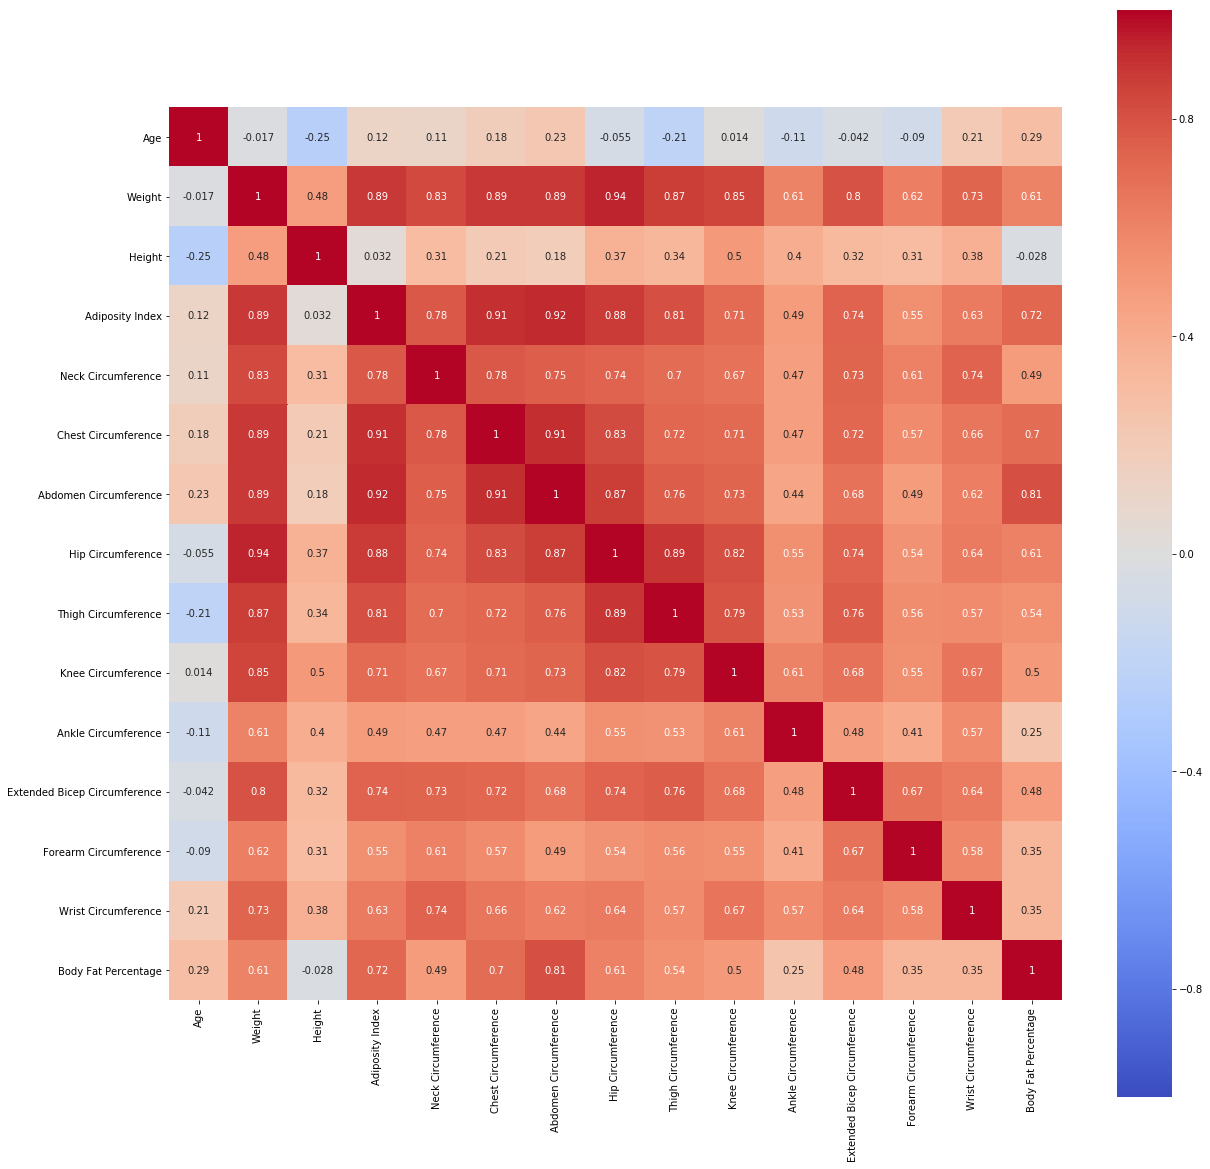

In [61]:
plt.figure(figsize=(20,20))
ax = sns.heatmap(np.corrcoef(data.T), vmin=-1,
                 vmax=1, center=0, cmap='coolwarm',
                 square=True, annot=True, xticklabels=column_names,
                 yticklabels=column_names)
plt.show()

# Search for data outliers

It's possible that some outliers in our data set are throwing things off. In order to quickly identify in which variables these outliers lie, we can check the `violin plot` and `box plot`.

/Users/jrpowers-luhn/miniconda3/envs/579/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


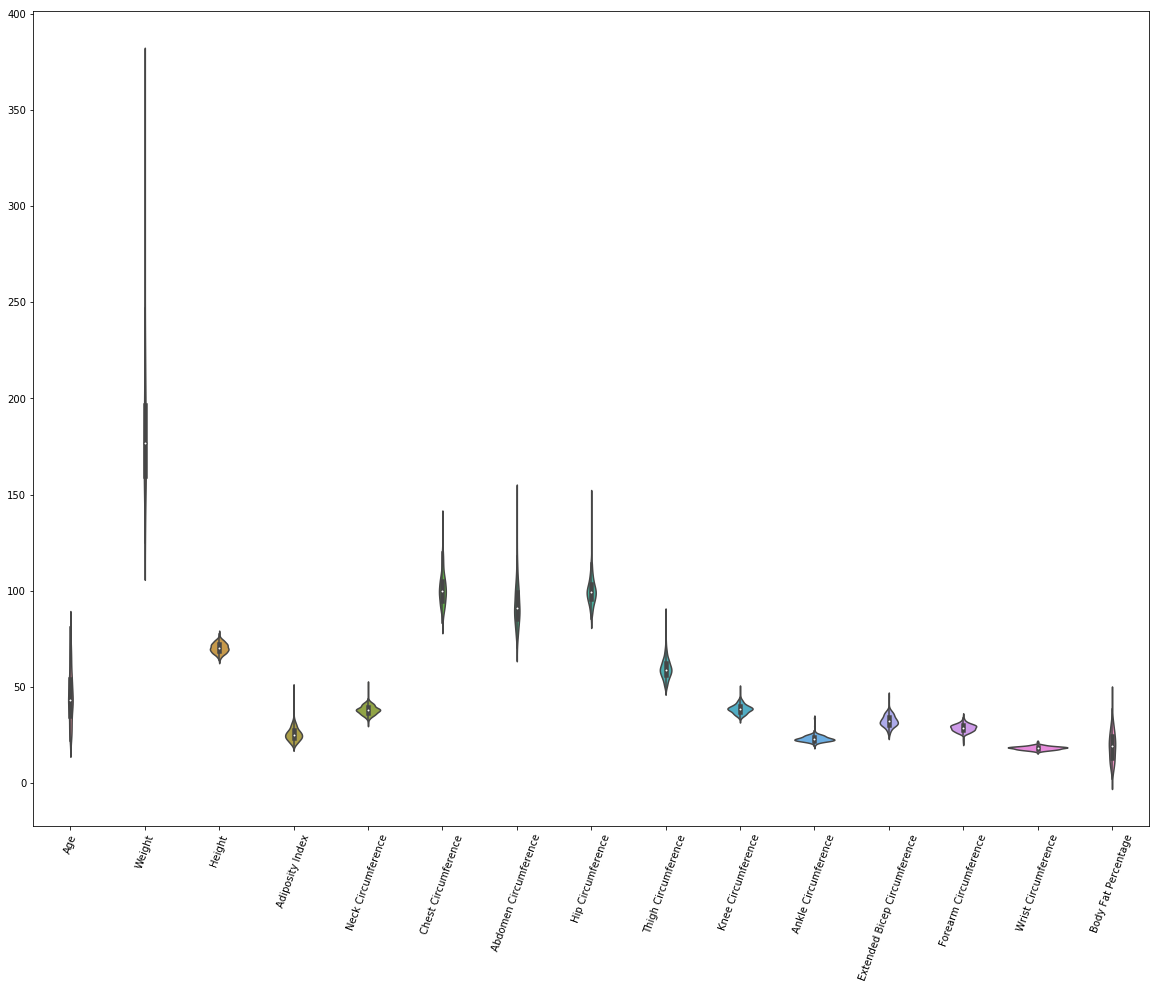

In [62]:
plt.figure(figsize=(20,15))
ax = sns.violinplot(data=data, names=column_names)
plt.xticks(rotation=70)
ax.set_xticklabels(column_names)
plt.show()

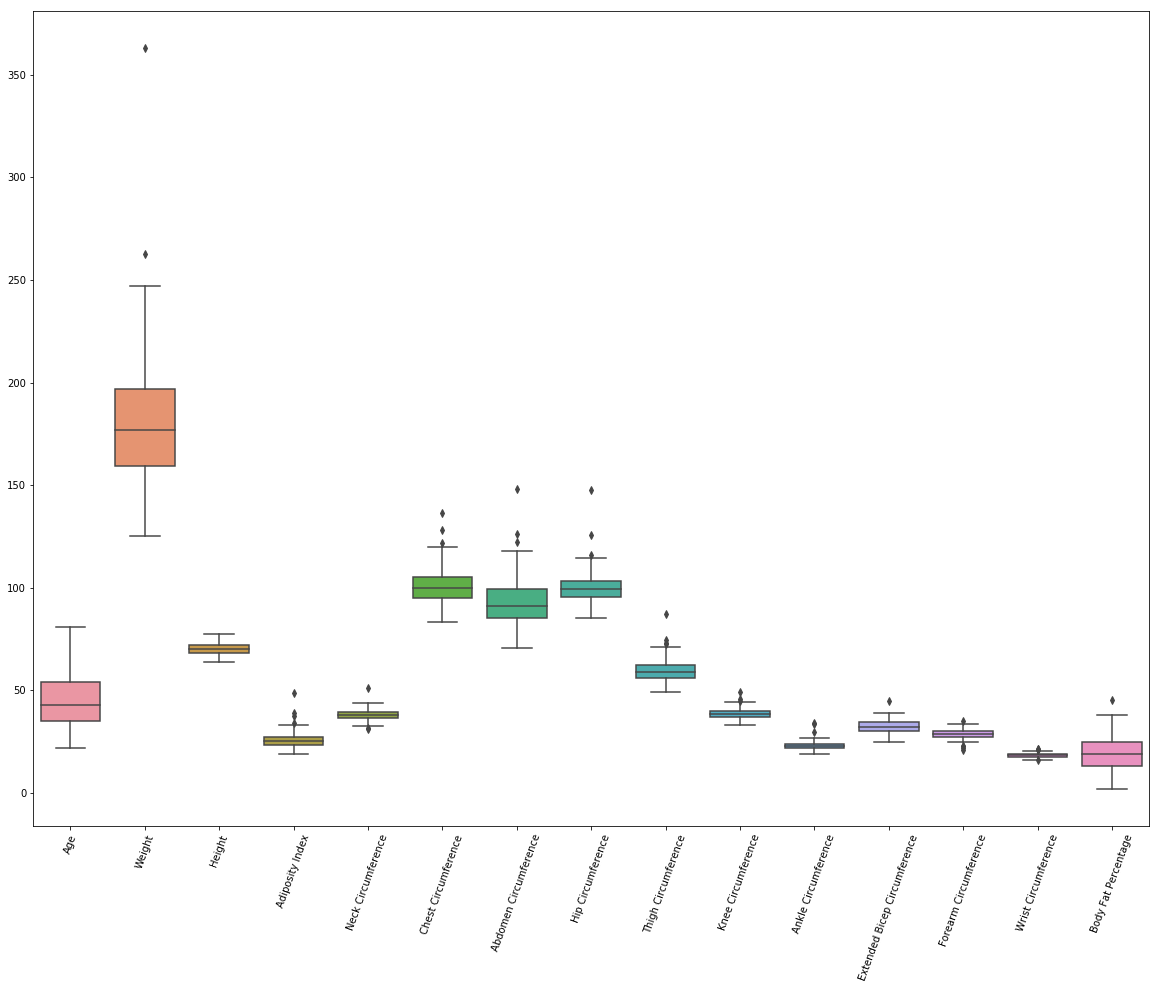

In [63]:
plt.figure(figsize=(20, 15))
ax = sns.boxplot(data=data)
plt.xticks(rotation=70)
ax.set_xticklabels(column_names)
plt.show()

From the box plot above it's clear that our most egregious outlier is a weight of nearly double our mean. In order to check this, we can quickly calculate how many standard deviations this value is away from the mean.

In [64]:
# Weights are in data column 1
weights = data[:, 1]
outlier_distance = (np.max(weights) - np.mean(weights)) / np.std(weights)
print(f'The outlier in the weights is {outlier_distance:0.2f} standard deviations from the mean')

The outlier in the weights is 6.33 standard deviations from the mean


While we're at it, let's perform the same analysis for each variable

In [65]:
max_outlier_distances = (np.max(data, axis=0) - np.mean(data, axis=0)) / np.std(data, axis=0)
print(max_outlier_distances)

[2.86075864 6.33372469 2.79589569 6.47149112 5.4601384  4.25392605
 5.18956686 6.77587169 5.40079345 4.41198674 6.36631982 4.20745437
 3.09234636 3.4332159  3.4157506 ]


This shows that there are still several outliers present in the data! These outliers were not as apparent in the box plot, likely because of the scaling. In order to make this easier to identify these outliers, let's re-scale our data set to be **MCUV** (mean centered with unit variance).

In [66]:
def zscore1(x, means=None, stds=None):
    """Scale a data set to mean center, unit variance
    
    If an array of mean values and an array of standard values are provided
    it will scale the dataset to those values instead.
    
    Parameters
    ----------
    x
        The dataset to be scaled
    means, optional
        An array of mean values. Should correspond to x.shape[1]
    stds, optional
        An array of standard deviation values. Should correspond to x.shape[1]
    """
    if means is None:
        means = np.mean(x, axis=0)
    if stds is None:
        stds = np.std(x, axis=0)

    xs = (x - means[np.newaxis, :]) / stds[np.newaxis, :]

    return xs, means, stds

In [67]:
data_s, data_means, data_stds = zscore1(data)

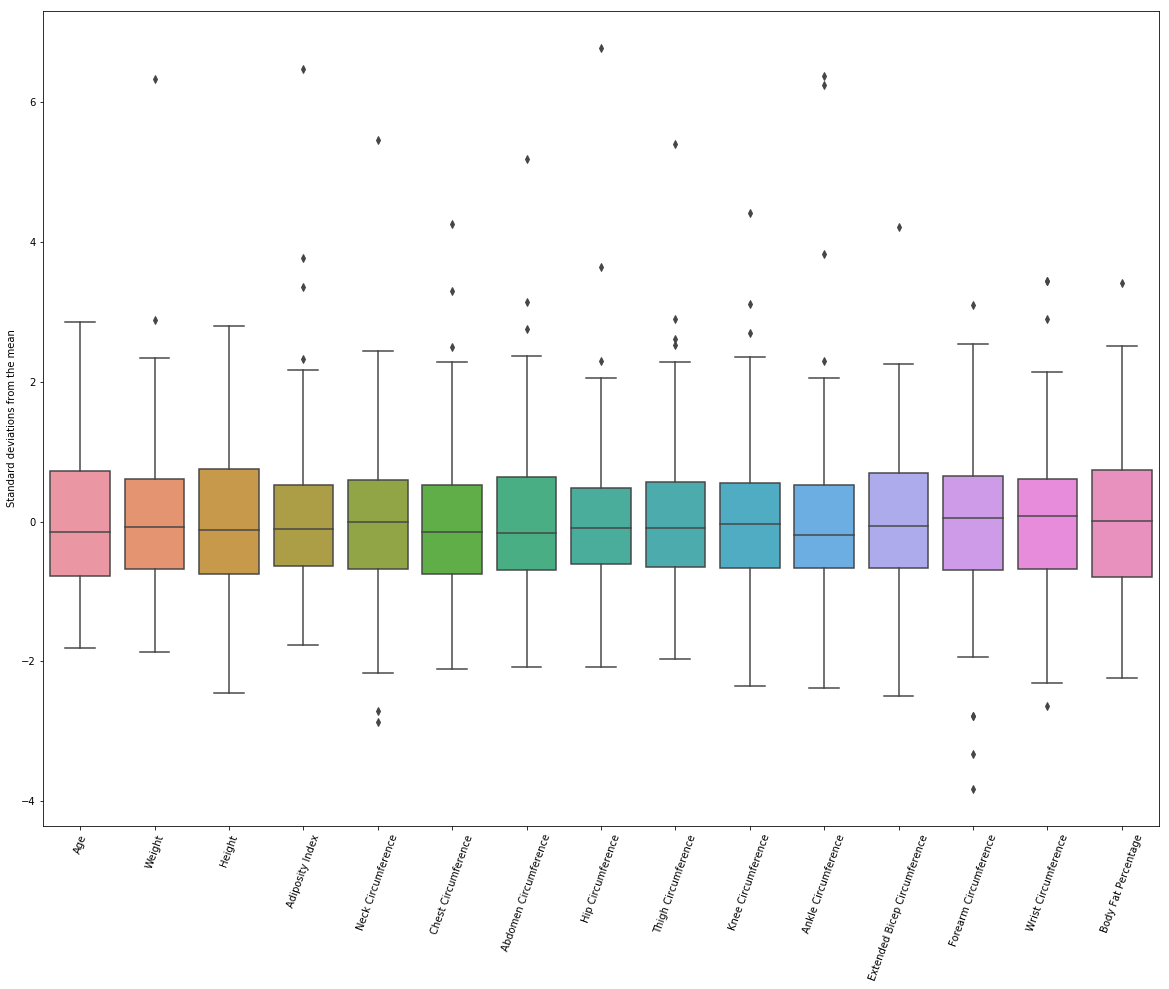

In [68]:
plt.figure(figsize=(20, 15))
ax = sns.boxplot(data=data_s)
plt.xticks(rotation=70)
ax.set_xticklabels(column_names)
ax.set_ylabel('Standard deviations from the mean')
plt.show()

From the box plot of the scaled data it's clear that there are a number of outliers which could be biasing our model.

/Users/jrpowers-luhn/miniconda3/envs/579/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


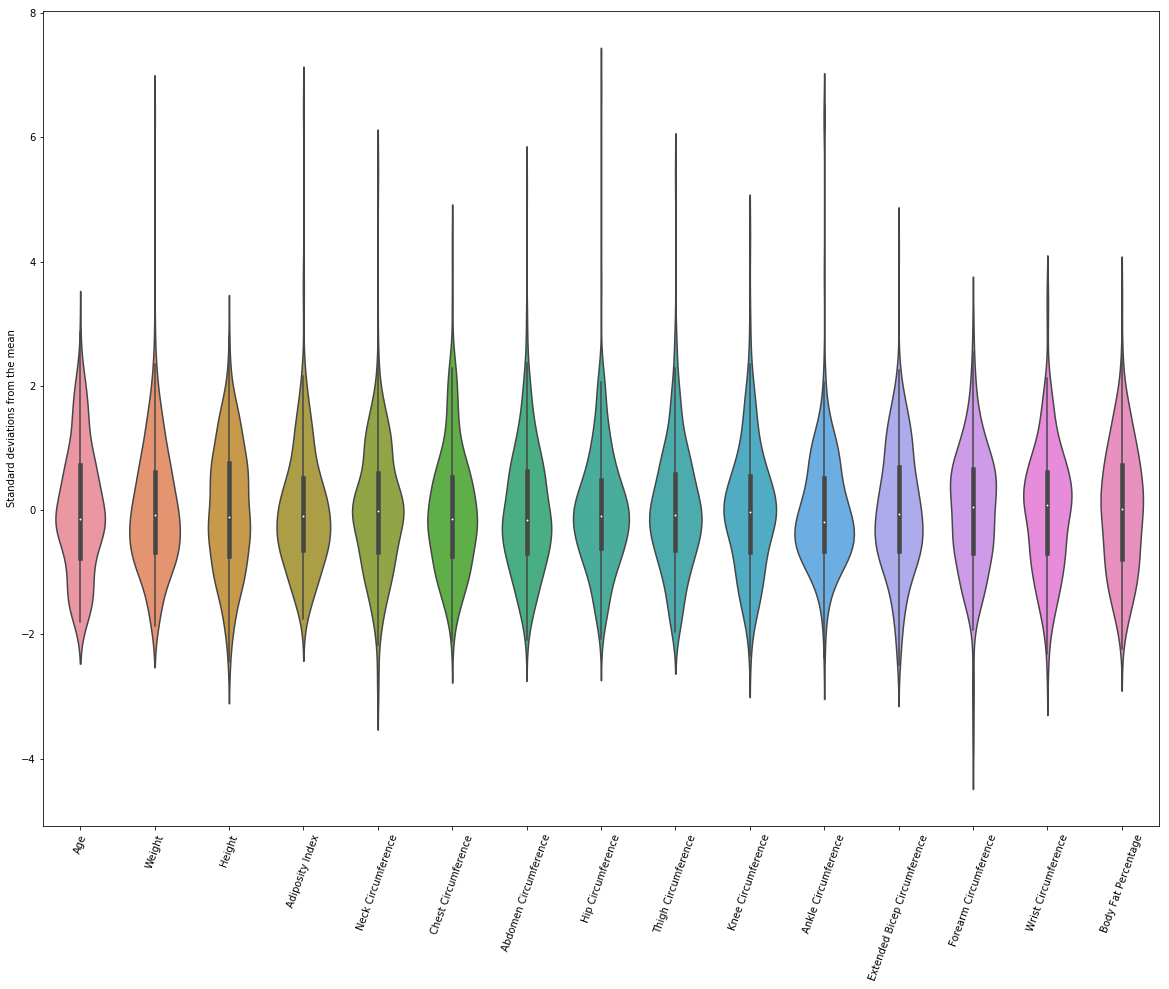

In [69]:
plt.figure(figsize=(20,15))
ax = sns.violinplot(data=data_s, names=column_names)
plt.xticks(rotation=70)
ax.set_xticklabels(column_names)
ax.set_ylabel('Standard deviations from the mean')
plt.show()

It's not clear from above what a violin plot brings to the table that a box and whiskers plot does not. But we can also employ the violin plot to validate that our testing data has the same approximate distribution as our training data by plotting the distribution of the training dataset on one side and the distribution of the test dataset on the other.

# Linear Regression

## Scale the data in the `train` set only

In [70]:
data_train_xs, training_means, training_stds = zscore1(data_train_x[:,:-1])

In the future I'll probably just use a `StandardScaler` from the scikit-learn library to accomplish the same thing.

In [71]:
np.mean(data_train_xs, axis=0)

array([ 2.62980202e-16, -1.25907974e-15, -5.06810608e-16,  4.40988028e-16,
       -3.54775179e-16, -6.27679163e-15, -2.40372588e-15, -7.00595696e-15,
        2.35689804e-15, -7.57308555e-16,  2.42078238e-15, -3.71056382e-15,
       -1.06128638e-14, -7.30390298e-15])

In [77]:
np.std(data_train_xs, axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## Reproduce the linear regression using scaled data

In [98]:
data_train_xst = np.hstack((data_train_xs, np.ones_like(data_train_xs[:,0]).reshape(-1, 1)))
scaled_coefficients = np.dot(np.dot(np.linalg.inv(np.dot(data_train_xst.T, data_train_xst)),
                                    data_train_xst.T), data_train_y)

In [99]:
for l, c in zip(column_names[:-1], scaled_coefficients[:-1]):
    print(f'{l} coefficient:\t\t{c}')
print(f'Intercept:\t\t{scaled_coefficients[-1]}')

Age coefficient:		0.6351201144259053
Weight coefficient:		-5.3938242491039
Height coefficient:		1.3797923829765821
Adiposity Index coefficient:		3.3302246048738375
Neck Circumference coefficient:		-1.5799011592948746
Chest Circumference coefficient:		-0.48248828358350854
Abdomen Circumference coefficient:		9.859913645987126
Hip Circumference coefficient:		-1.5079105395548207
Thigh Circumference coefficient:		0.9289461567789055
Knee Circumference coefficient:		-0.3023890509470748
Ankle Circumference coefficient:		0.1824335995776174
Extended Bicep Circumference coefficient:		0.991242403059223
Forearm Circumference coefficient:		0.882960172206358
Wrist Circumference coefficient:		-1.4907823573494035
Intercept:		18.27932960893855


Examination of the coefficients with scaling applied reveals that the most strongly predictive values are Abdomen circumference, Weight, and Adiposity index. Other coefficients are smaller (~2x smaller or more than Adiposity). It's worth noting, however, that a lot of these values have covariance (as seen above). It's also interesting to note that the intercept is the same as it was on the unscaled data.

## Find the single best predictor of body fat percentage

Based on the result of the linear regression above, I expect this to be Abdomen circumference

In [100]:
def regress(x, y):
    """Perform linear regression using x to predict y
    
    Parameters
    ----------
    x : numpy.ndarray
        Numpy array. It should contain more rows than columns and should always be 2d. 
        A column for the intercept will be added by this function.
    y : numpy.ndarray
        Output/values to be predicted. Should contain the same number of rows as x
    
    Returns
    -------
    numpy.ndarray
        Coefficients of the linear regression terms.
    """
    x = one_pad(x)
    
    tmp = np.dot(x.T, x)
    tmp = np.linalg.inv(tmp)
    tmp = np.dot(tmp, x.T)
    
    alpha = np.dot(tmp, y)
    
    return alpha

In [101]:
def one_pad(x):
    """Adds a column of one to a 2d matrix of data
    
    Parameters
    ----------
    x : numpy.ndarray
        2d array of data
    
    Returns
    -------
    numpy.ndarray
        x with intercept column added for regression
    """
    one_col = np.ones_like(x[:,0]).reshape((-1, 1))
    
    return np.hstack((x, one_col))

In [102]:
print(scaled_coefficients)
print(regress(data_train_xs, data_train_y))
assert np.allclose(scaled_coefficients, regress(data_train_xs, data_train_y))

[ 0.63512011 -5.39382425  1.37979238  3.3302246  -1.57990116 -0.48248828
  9.85991365 -1.50791054  0.92894616 -0.30238905  0.1824336   0.9912424
  0.88296017 -1.49078236 18.27932961]
[ 0.63512011 -5.39382425  1.37979238  3.3302246  -1.57990116 -0.48248828
  9.85991365 -1.50791054  0.92894616 -0.30238905  0.1824336   0.9912424
  0.88296017 -1.49078236 18.27932961]


In [190]:
def rmse(predictions, true):
    """Calculate the mean squared error for a prediction
    
    Parameters
    ----------
    predictions : numpy.ndarray
    true: numpy.ndarray
    
    Returns
    -------
    float
    
    Raises
    ------
    ValueError
        If `predictions` and `true` are not the same length
    
    Examples
    --------
    >>> a = np.arange(5)
    >>> rmse(a, a+1)
    2.2360679774997898
    
    >>> rmse(np.ones(4), np.ones(4))
    0.0
    """
    return np.linalg.norm(predictions - true)

In [193]:
def model(columns, x_train, y_train, x_test, y_test, error=rmse):
    """Peforms linear regression on a subset of data
    
    Parameters
    ----------
    columns : tuple of int
        A tuple of the columns to be included in the input data
    x : numpy.ndarray
        The training data, not one-padded, not scaled
    y : numpy.ndarray
        The training data outputs
    error : function, default is `rmse`
        function that takes the true values and predicted values
        and returns some cost as a float.
    
    Returns
    -------
    float
        root-mean-squared error on test set
    
    Example
    -------
    >>> x = np.arange(16).reshape((-1, 4))
    >>> y = np.sum(x, axis=1)
    """
    # Scale the training data
    xs_train, means, stds = zscore1(x_train)
    
    # Scale the testing data to the same values
    xs_test = (x_test - means) / stds
    
    # Assemble the training data by selecting columns
    train_cols = np.array([xs_train[:,i] for i in columns]).T
    test_cols = np.array([xs_test[:,i] for i in columns]).T
    
    # Perform the regression
    coefficients = regress(train_cols, y_train)
    
    # Calculate the test set outputs
    y_pred = np.dot(one_pad(test_cols), coefficients)
    
    # Calculate the RMSE on the test set
    error = error(y_pred, y_test)
    
    # Return that value
    return error

In [194]:
model((1,2,3,4), data_train_x[:,:-1], data_train_y, data_test[:,:-1], data_test[:,-1])

35.41684860817374

## Examine scores for each predictor individually

In [197]:
performance = [model([i], data_train_x[:,:-1], data_train_y, data_test[:,:-1], data_test[:,-1]) for i in range(14)]

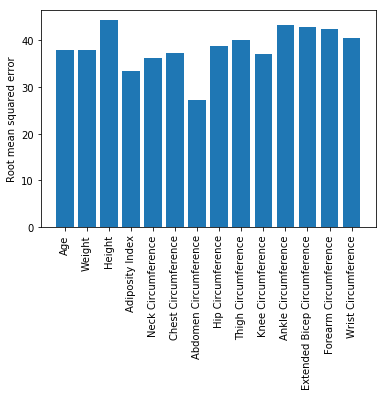

In [204]:
f = plt.figure()
plt.bar(x=column_names[:-1], height=performance)
plt.ylabel('Root mean squared error')
plt.xticks(rotation='vertical')
plt.show()

This corresponds to the most correlated variable and the variable with the highest coefficient when all variables were used to perform a regression. Still, all of these models have a large error considering the range of the predicted value.

In [205]:
np.max(data[:,-1])

45.1

In [206]:
np.min(data[:,-1])

1.9

In [207]:
np.std(data[:,-1])

7.634198521618484

In [208]:
np.mean(data[:,-1])

19.023481781376514

# Linear regression in two variables

For this I will use a library to generate all possible combinations of two variables

In [209]:
from itertools import combinations

In [250]:
two_column_combinations = combinations([_ for _ in range(data.shape[1]-1)], 2)
two_input_performance = [model(c, data_train_x[:,:-1],
                               data_train_y, data_test[:,:-1],
                               data_test[:,-1]) for c in two_column_combinations]
two_model_performance_grid = np.zeros((14, 14))
mask = np.zeros((14, 14))
mask[np.triu_indices_from(mask)] = True
two_column_combinations = combinations([_ for _ in range(data.shape[1]-1)], 2)
for c in two_column_combinations:
    two_model_performance_grid[c[1], c[0]] = model(c, data_train_x[:,:-1],
                                             data_train_y, data_test[:,:-1],
                                             data_test[:,-1])

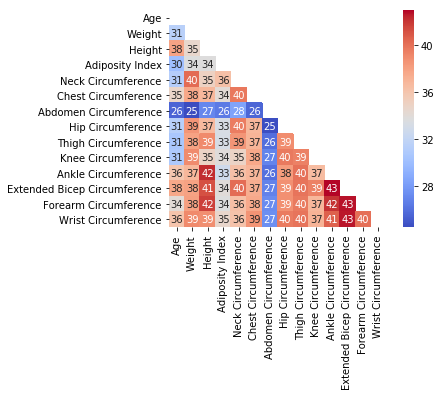

In [251]:
f = plt.figure()
sns.heatmap(two_model_performance_grid, square=True, annot=True,
            xticklabels=column_names[:-1], yticklabels=column_names[:-1],
            mask=mask, cmap='coolwarm',
            vmin=np.min(two_input_performance),
            vmax=np.max(two_input_performance))
plt.show()